In [1]:
from pathlib import Path

import librosa
import numpy
import pysptk
import pyworld

from become_yukarin.config import create_from_json as create_config
from become_yukarin.data_struct import Wave
from become_yukarin.dataset.dataset import *
from become_yukarin import VoiceChanger

from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path_input = Path('/mnt/dwango/hiroshiba/become-yukarin/dataset/hiho-wave/hiho-pause-atr503-subset').expanduser() / 'hiho-pause-atr-A01.wav'
path_target = Path('/mnt/dwango/hiroshiba/become-yukarin/dataset/yukari-wave/yukari-pause-atr503-subset').expanduser() / 'yukari-pause-atr-A01.wav'

wave_file_load = WaveFileLoadProcess(
    sample_rate=24000,
    top_db=None,
    pad_second=0.1,
)
acoustic_feature = AcousticFeatureProcess(
    frame_period=5,
    order=25,
    alpha=pysptk.util.mcepalpha(wave_file_load._sample_rate),
)

base_model = Path('/mnt/dwango/hiroshiba/become-yukarin/true-hiho-yukari-pause-notopdb/')
config = create_config(base_model / 'config.json')
voice_changer = VoiceChanger(config, base_model / 'predictor_520000.npz')

/home/kazuyuki_hiroshiba/.pyenv/versions/miniconda3-4.1.11/envs/become-yukarin/lib/python3.6/site-packages/chainer/utils/experimental.py:104: FutureWarning: chainer.functions.pooling.MaxPoolingND is experimental. The interface can change in the future.
  FutureWarning)


In [3]:
def show_feature(f):
    plt.figure(figsize=(14, 9))

    plt.subplot(6, 1, 1)
    plt.plot(f.f0)

    plt.subplot(6, 1, 2)
    plt.plot(f.f0!=0)

    plt.subplot(6, 1, 3)
    plt.plot(f.mfcc)

    plt.subplot(2, 1, 2)
    plt.imshow(numpy.log(f.spectrogram.T), origin='lower', aspect='auto')

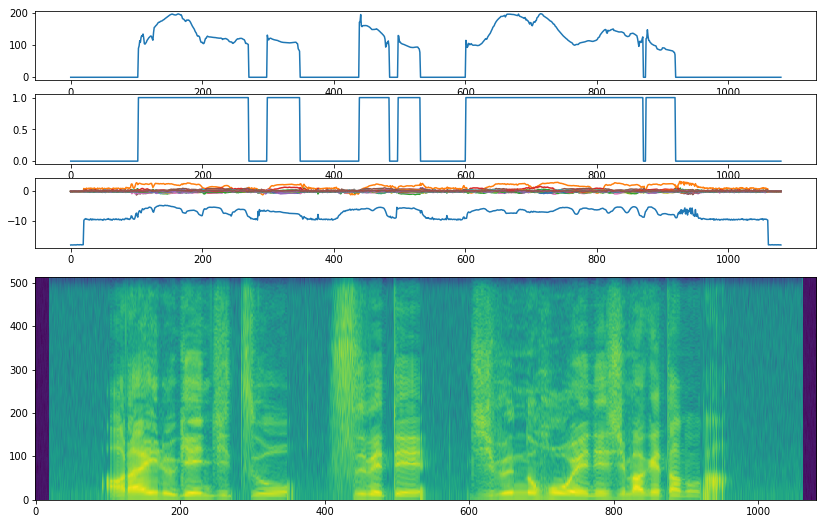

In [4]:
w_in = wave_file_load(path_input, test=True)
f_in = acoustic_feature(w_in, test=True)
show_feature(f_in)

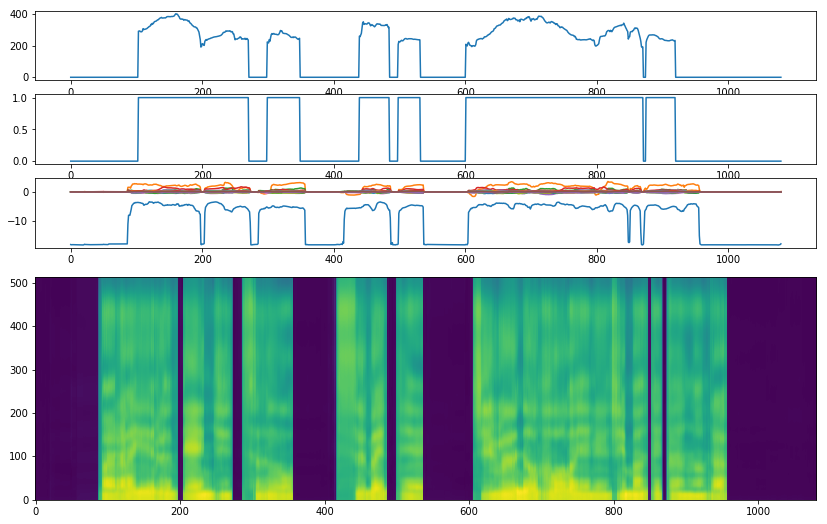

In [5]:
f_out = voice_changer.convert_to_feature(f_in)
show_feature(f_out)

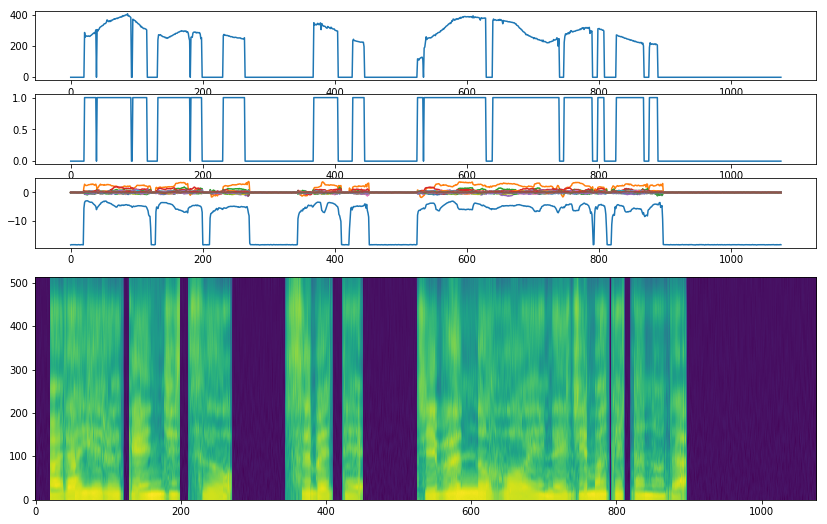

In [6]:
w_target = wave_file_load(path_target, test=True)
f_target = acoustic_feature(w_target, test=True)

fftlen = pyworld.get_cheaptrick_fft_size(wave_file_load._sample_rate)
spectrogram = pysptk.mc2sp(
    f_target.mfcc,
    alpha=acoustic_feature._alpha,
    fftlen=fftlen,
)

f_target = AcousticFeature(
    f0=f_target.f0,
    spectrogram=spectrogram,
    aperiodicity=f_target.aperiodicity,
    mfcc=f_target.mfcc,
    voiced=f_target.voiced,
)

show_feature(f_target)

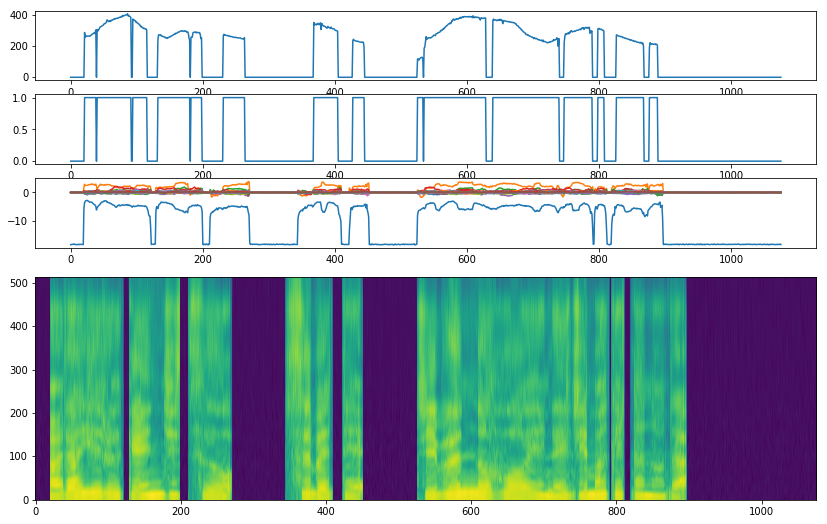

In [7]:
path_base = Path('/mnt/dwango/hiroshiba/become-yukarin/dataset/aligned-feature/aligned-yukari-pause-hiho-pause-atr-notopdb-smart/yukari-pause')
path_mean = path_base / 'mean.npy'
path_var = path_base / 'var.npy'

load_feature = AcousticFeatureLoadProcess()
normalize = AcousticFeatureNormalizeProcess(mean=load_feature(path_mean), var=load_feature(path_var))
denormalize = AcousticFeatureDenormalizeProcess(mean=load_feature(path_mean), var=load_feature(path_var))

f_norm = normalize(f_target)

noise_f0 = numpy.random.randn(*f_norm.f0.shape) * 0.01
noise_mfcc = numpy.random.randn(*f_norm.mfcc.shape) * 0.01

f_target_noize = AcousticFeature(
    f0=f_norm.f0 + noise_f0,
    spectrogram=numpy.nan,
    aperiodicity=numpy.nan,
    mfcc=f_norm.mfcc + noise_mfcc,
    voiced=f_target.voiced,
)
f_target_noize = denormalize(f_target_noize)

fftlen = pyworld.get_cheaptrick_fft_size(wave_file_load._sample_rate)
spectrogram = pysptk.mc2sp(
    f_target_noize.mfcc,
    alpha=acoustic_feature._alpha,
    fftlen=fftlen,
)

f_target_noize = AcousticFeature(
    f0=f_target_noize.f0,
    spectrogram=spectrogram,
    aperiodicity=f_target_noize.aperiodicity,
    mfcc=f_target_noize.mfcc,
    voiced=f_target_noize.voiced,
)

show_feature(f_target_noize)